In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv("data.csv")
data_copy = data

### --- Missing values initially ---

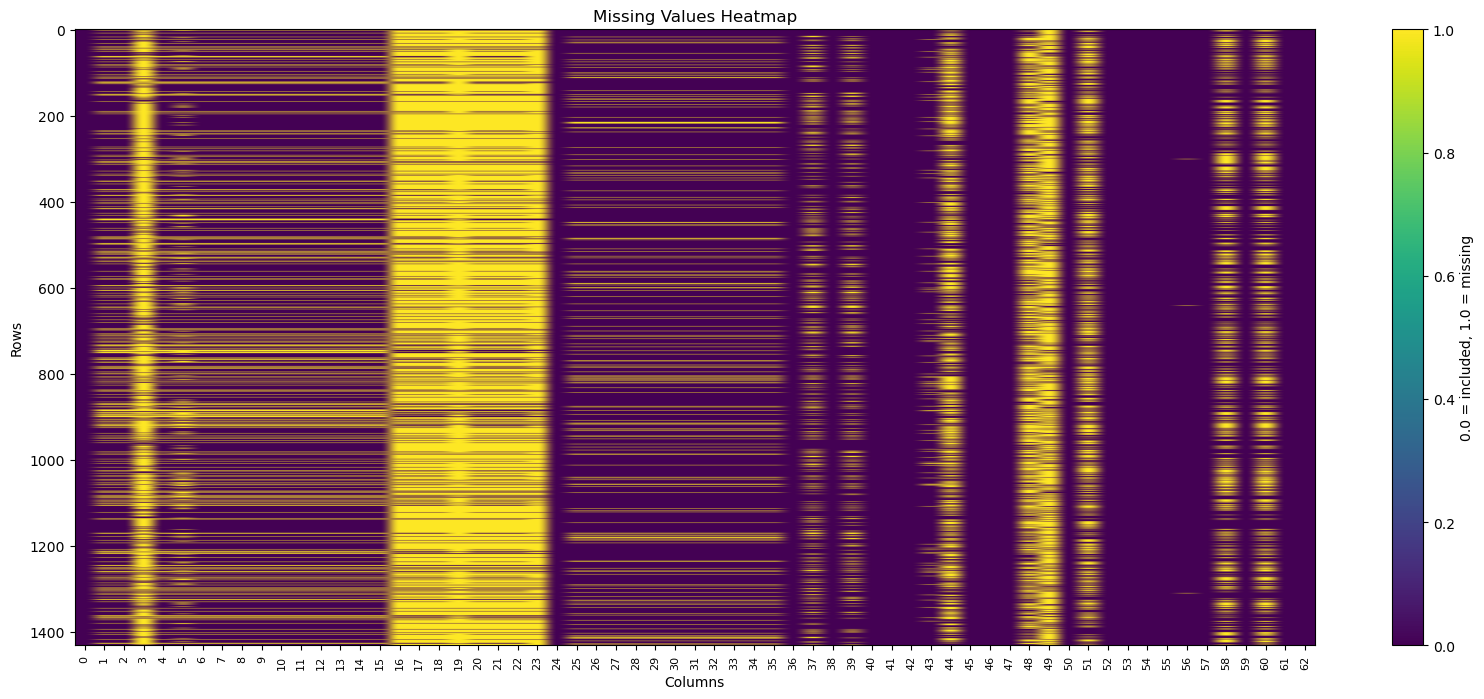

In [18]:
plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(data.isna(), aspect='auto', cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0.0 = included, 1.0 = missing")
plt.xticks(
    ticks=np.arange(0, len(data.columns), 1),
    rotation=90,
    fontsize=8
)
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

### --- Deleting rows with missing values from the same people ---

In [24]:
# these are the columns 1-2, 6-15 and 24-43
empty_rows = (
    list(data_copy.columns[1:3]) +
    list(data_copy.columns[6:16]) +
    list(data_copy.columns[24:44])
)
data_copy = data_copy.dropna(subset=empty_rows)

### --- Missing values after deleting ---

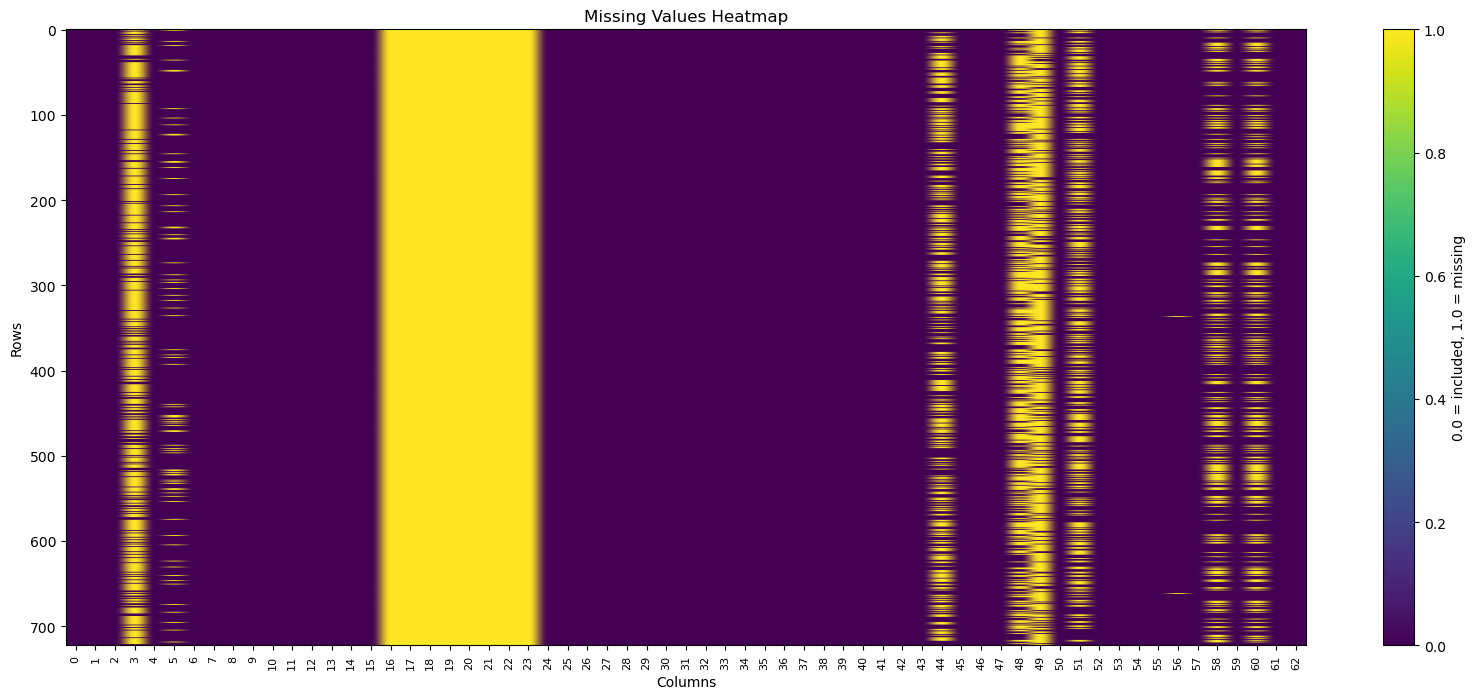

In [25]:
plt.rcParams["figure.figsize"] = (20,8)
plt.imshow(data_copy.isna(), aspect='auto', cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0.0 = included, 1.0 = missing")
plt.xticks(
    ticks=np.arange(0, len(data.columns), 1),
    rotation=90,
    fontsize=8
)
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

<Axes: xlabel='Does your employer provide mental health benefits as part of healthcare coverage?'>

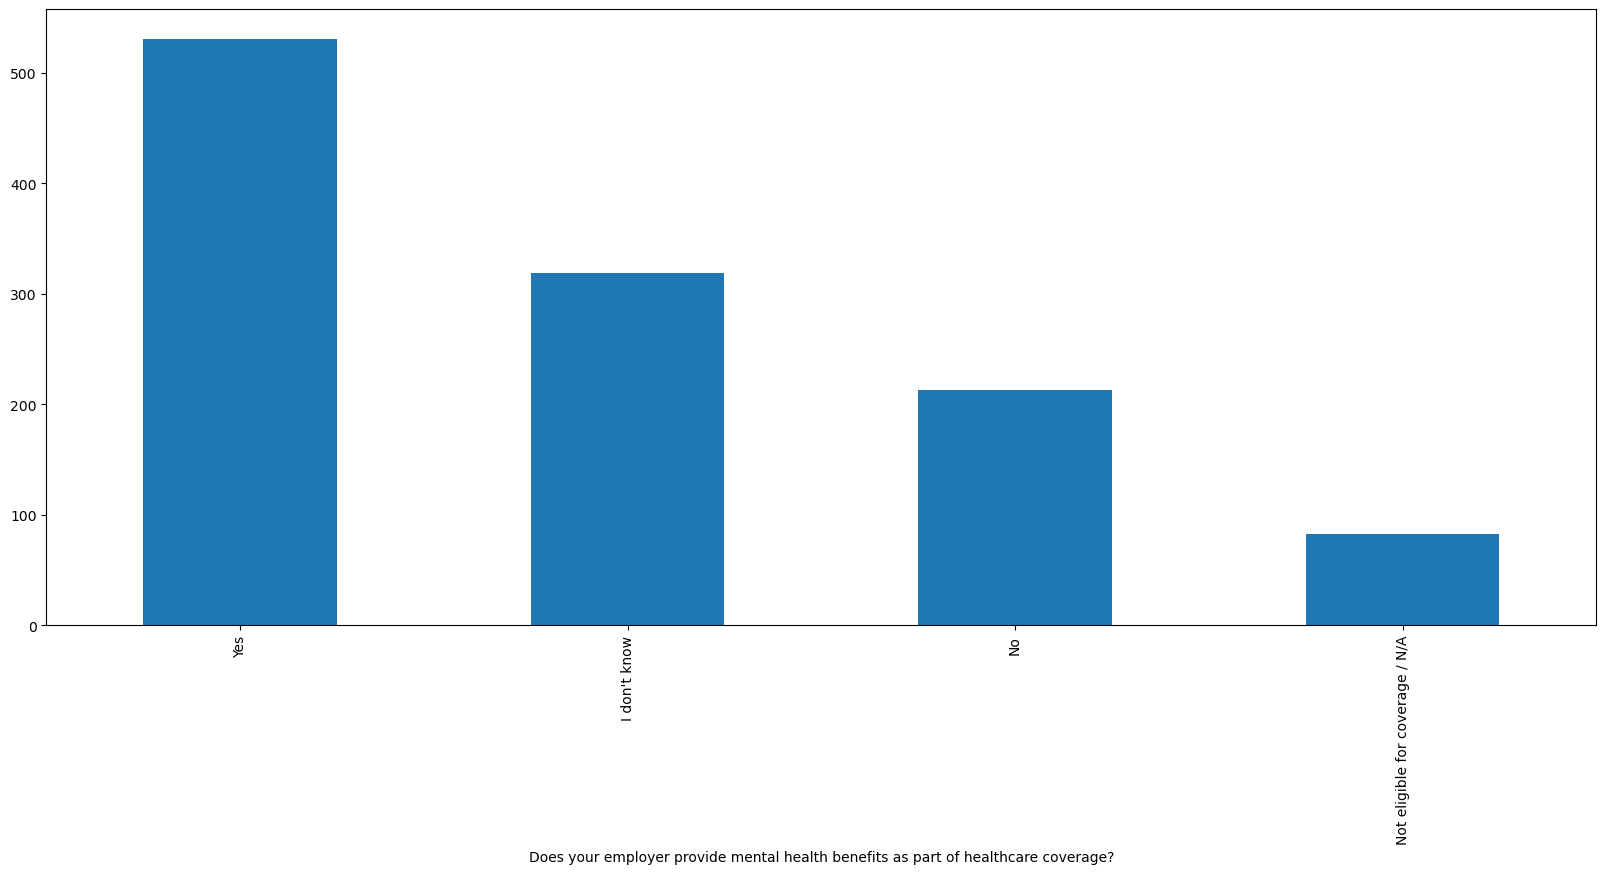

In [26]:
data["Does your employer provide mental health benefits as part of healthcare coverage?"].value_counts().plot(kind="bar")